# Propensity Modeling

In [20]:
import numpy as np
import pandas as pd
import pickle
# import urllib
# from tqdm import tqdm, trange, tqdm_pandas
# import os
# from user_agents import parse
# import datetime
from time import time
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
# pd.set_option('display.max_columns', 1000)

##  1. Data

In [6]:
%%time
with open( "../Data/Feature_Engineering/df_features_normalize.p", "rb" ) as f:
    df_features = pickle.load(f)

with open( "../Data/Feature_Engineering/df_label.p", "rb" ) as f:
    df_label = pickle.load(f)

CPU times: user 729 ms, sys: 4.3 s, total: 5.03 s
Wall time: 12.6 s


In [7]:
%%time
X = df_features
Y = df_label

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


### 1.1 Split data to training set, validation set and test set

In [8]:
print(X.shape)
bar_80 = np.floor(X.shape[0]*0.8).astype(int)
bar_80=bar_80+1
bar_80

(220047, 2357)


176038

In [9]:
X_train=X[:bar_80]
Y_train=Y[:bar_80]
X_test=X[bar_80:]
Y_test=Y[bar_80:]

## 2.0 Feature Selection

In [10]:
%%time
clf=RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,  bootstrap=True, 
                           oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False,
                           class_weight=None)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 52.7 µs


In [11]:
%%time
clf.fit(X_train, Y_train)

CPU times: user 31.2 s, sys: 680 ms, total: 31.9 s
Wall time: 7.89 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
clf.feature_importances_ 

array([ 0.0244983 ,  0.03762341,  0.02062135, ...,  0.00055788,
        0.000105  ,  0.00056723])

In [13]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

(220047, 80)

In [14]:
X_train=X_new[:bar_80]
Y_train=Y[:bar_80]
X_test=X_new[bar_80:]
Y_test=Y[bar_80:]

## 2. Random Forest Classifier


|  Parameters  |  Explanation |  
|---|---|---|---|---|
|  n_estimators | The number of trees in the forest  |   
| criterion  | The function to measure the quality of a split.  |   
|  max_depth | The number of features to consider when looking for the best split  |   
|  max_depth | The maximum depth of the tree.  |   
|  min_samples_split |   |  
| min_samples_leaf  |   |  
| max_features  |   |  
| max_leaf_nodes  |   |   
| bootstrap  |   |   
| oob_score  |   |   
|  n_jobs |   |   
|  random_state |   |   
|  verbose |   |  
|  warm_start |   |   
|  class_weight |   |   




**Random Search**

In [22]:
clf = RandomForestClassifier()

param_dist = {"n_estimators":[100,300,500,800,1000],
              "max_depth": [3, 5, 8, 15, 25, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
start = time()
random_search.fit(X_train, Y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

KeyboardInterrupt: 

In [37]:
%%time
clf=RandomForestClassifier(n_estimators=10, criterion='gini', 
                           min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,  bootstrap=True, 
                           oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False,
                           class_weight=None)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 42.4 µs


In [38]:
%%time
clf.fit(X_train, Y_train)

CPU times: user 3.53 s, sys: 73 ms, total: 3.61 s
Wall time: 2.11 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### 2.1 Save Model

In [39]:
%%time
path = '../Data/Propensity_Modeling/RandomForest.pkl'
joblib.dump(clf, path)

# clf=RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
#                            min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,  bootstrap=True, 
#                            oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False,
#                            class_weight=None)

CPU times: user 13 ms, sys: 12 ms, total: 25 ms
Wall time: 947 ms


In [40]:
Y_predict=clf.predict(X_test)

### 2.2 Load Model

In [41]:
%%time
# load the model from disk
path = '../Data/Propensity_Modeling/RandomForest.pkl'
Random_Forest_Classifier = joblib.load(path)

# result = loaded_model.score(X_test, Y_test)
# print(result)

CPU times: user 18 ms, sys: 12 ms, total: 30 ms
Wall time: 1.14 s


## 3. Result Analysis

### 3.1 Accuracy Rate

In [42]:
Y_pred = clf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.934218000863


In [43]:
# Result with 100 trees
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.95      0.98      0.96     37065
          1       0.85      0.71      0.77      6944

avg / total       0.93      0.93      0.93     44009



In [44]:
sum(Y_test)/len(Y_test)

0.15778590742802609

### 3.2 Confusion matrix

In [45]:
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix is:
 [[36160   905]
 [ 1990  4954]]

Plot of Confusion Matrix is:


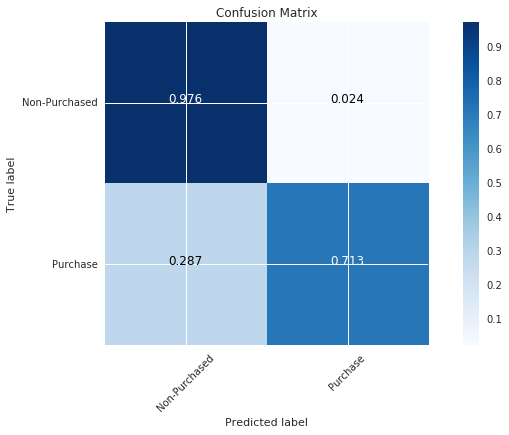

In [46]:
Y_pred = clf.predict(X_test)
# cfm = confusion_matrix(y_true, y_pred, labels
cfm = confusion_matrix(Y_test, Y_pred, labels=[0, 1])
print('Confusion Matrix is:\n',confusion_matrix(Y_test, Y_pred))
print('\nPlot of Confusion Matrix is:')
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["Non-Purchased", "Purchase"], normalize=True)

**feature Importance check**

In [47]:
clf.feature_importances_

array([ 0.02182581,  0.03924936,  0.02544993,  0.01864292,  0.00470643,
        0.03958883,  0.01939232,  0.04722465,  0.03262547,  0.01194625,
        0.0984629 ,  0.11658181,  0.01575379,  0.08556417,  0.0659395 ,
        0.07062036,  0.00197524,  0.00221935,  0.00190454,  0.00476846,
        0.00115781,  0.00596204,  0.00183362,  0.00225924,  0.00076644,
        0.00097929,  0.00081595,  0.02250847,  0.00155817,  0.00204431,
        0.00072581,  0.00056996,  0.00382733,  0.00047779,  0.00032463,
        0.00274455,  0.00031282,  0.00091057,  0.00099617,  0.00068278,
        0.00174079,  0.00615246,  0.00092005,  0.00096566,  0.00644169,
        0.00091886,  0.00145554,  0.00219916,  0.0024875 ,  0.00376072,
        0.00187275,  0.00099534,  0.11840752,  0.00359681,  0.04664621,
        0.00080303,  0.00033337,  0.00062785,  0.00057101,  0.00035909,
        0.00111609,  0.00073654,  0.00069242,  0.00070658,  0.00052631,
        0.00084645,  0.00405821,  0.00153628,  0.00047301,  0.00

### 3.3 ROC AUC

In [51]:
n_class=0
Y_prob = clf.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, Y_prob[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_prob[:,1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

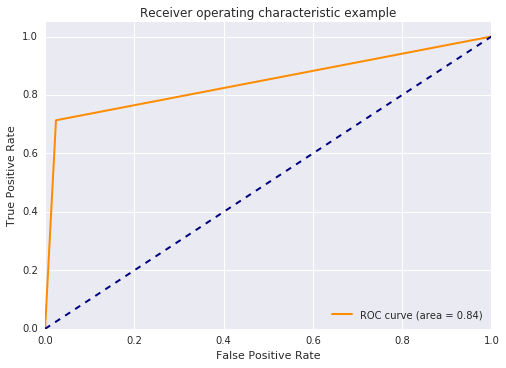

In [53]:
# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

---